## Dependencias

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Lectura de datos

In [ ]:
!unzip dia/dia.zip -d dia
!unzip noche/noche.zip -d noche

Archive:  dia/dia.zip
   creating: dia/dia/
  inflating: dia/__MACOSX/._dia      
  inflating: dia/dia/images296.jpg   
  inflating: dia/__MACOSX/dia/._images296.jpg  
  inflating: dia/dia/images282.jpg   
  inflating: dia/__MACOSX/dia/._images282.jpg  
  inflating: dia/dia/images255.jpg   
  inflating: dia/__MACOSX/dia/._images255.jpg  
  inflating: dia/dia/images26.jpg    
  inflating: dia/__MACOSX/dia/._images26.jpg  
  inflating: dia/dia/images241.jpg   
  inflating: dia/__MACOSX/dia/._images241.jpg  
  inflating: dia/dia/images32.jpg    
  inflating: dia/__MACOSX/dia/._images32.jpg  
  inflating: dia/dia/images269.jpg   
  inflating: dia/__MACOSX/dia/._images269.jpg  
  inflating: dia/dia/image22.jpeg    
  inflating: dia/__MACOSX/dia/._image22.jpeg  
  inflating: dia/dia/images123.jpg   
  inflating: dia/__MACOSX/dia/._images123.jpg  
  inflating: dia/dia/images137.jpg   
  inflating: dia/__MACOSX/dia/._images137.jpg  
  inflating: dia/dia/landscape-2308981_1280.jpg  
  inflating

In [ ]:
!rm -rf dia/dia.zip
!rm -rf noche/noche.zip

In [ ]:
!mkdir dataset
!cp -r dia dataset/dia
!cp -r noche dataset/noche

## Aumento de datos

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 10,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 5,
    zoom_range = [0.7, 1.3],
    validation_split = 0.2
)

data_gen_entrenamiento = datagen.flow_from_directory("/content/dataset",
                                                     target_size = (224,224),
                                                     batch_size = 32, shuffle = True,
                                                     subset = "training")

data_gen_pruebas = datagen.flow_from_directory("/content/dataset",
                                                     target_size = (224,224),
                                                     batch_size = 32, shuffle = True,
                                                     subset = "validation")

Found 727 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


## Visualizando algunas imágenes

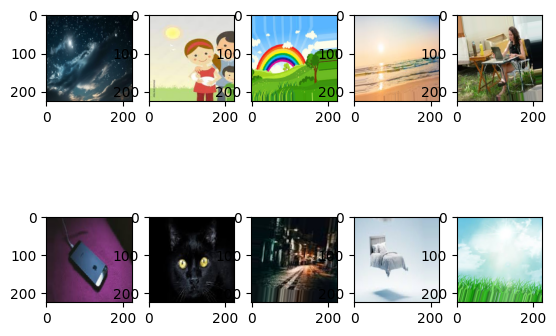

In [ ]:
for imagenes, etiquetas in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imagenes[i])

  break
plt.show()

## Cargando un modelo preentrenado

In [ ]:
url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

In [ ]:
mobilenetv2.trainable = False

In [ ]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation="softmax")
])

modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Entrenamiento del modelo

In [ ]:
EPOCAS = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/20
23/23 [==============================] - 24s 771ms/step - loss: 0.7655 - accuracy: 0.6259 - val_loss: 0.4402 - val_accuracy: 0.7944
Epoch 2/20
23/23 [==============================] - 14s 640ms/step - loss: 0.3896 - accuracy: 0.8267 - val_loss: 0.2950 - val_accuracy: 0.8778
Epoch 3/20
23/23 [==============================] - 15s 665ms/step - loss: 0.2854 - accuracy: 0.8982 - val_loss: 0.2586 - val_accuracy: 0.8833
Epoch 4/20
23/23 [==============================] - 15s 628ms/step - loss: 0.2479 - accuracy: 0.9051 - val_loss: 0.2243 - val_accuracy: 0.9278
Epoch 5/20
23/23 [==============================] - 14s 621ms/step - loss: 0.2083 - accuracy: 0.9216 - val_loss: 0.2386 - val_accuracy: 0.9222
Epoch 6/20
23/23 [==============================] - 16s 722ms/step - loss: 0.2020 - accuracy: 0.9257 - val_loss: 0.1950 - val_accuracy: 0.9111
Epoch 7/20
23/23 [==============================] - 14s 624ms/step - loss: 0.1828 - accuracy: 0.9340 - val_loss: 0.2076 - val_accuracy: 0.9222

## Predicciones

**Nota:**

Si usamos '*data_gen_entrenamiento.class_indices*' vemos que las clases son:

- dia : 0
- noche : 1

In [ ]:
def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

In [ ]:
ruta = "/content/img_dia.jpeg"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 1s 1s/step
0


In [ ]:
ruta = "/content/img_noche.jpeg"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 34ms/step
1
